In [1]:
import pymc as pm
import numpy as np
import arviz as az
import pandas as pd
import pytensor.tensor.subtensor as st
from itertools import combinations

%load_ext lab_black
%load_ext watermark

# Simvastatin

This one is about factorial designs (2-way ANOVA) with sum-to-zero and corner constraints.

Adapted from [Unit 7: simvastatin.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit7/simvastatin.odc).

Data can be found [here](https://raw.githubusercontent.com/areding/6420-pymc/main/data/simvastatin_data.txt).

Associated lecture videos: Unit 8 lessons 8 and 9

Thanks to [Anthony Miyaguchi](https://github.com/acmiyaguchi) for updating this example!

## Problem statement

In a quantitative physiology lab II at Georgia Tech, students were asked to find a therapeutic model to test on MC3T3-E1 cell line to enhance osteoblastic growth.
The students found a drug called Simvastatin, a cholesterol lowering drug to test on these cells. Using a control and three different concentrations: $10^{-9}$, $10^{-8}$ and $10^{-7}$ M, cells were treated with the drug.
These cells were plated on four, 24 well plates with each well plate having a different treatment.
To test for osteoblastic differentiation an assay, pNPP, was used to test for alkaline phosphatase activity.
The higher the alkaline phosphatase activity the better the cells are differentiating, and become more bone like.
This assay was performed 6 times total within 11 days. Each time the assay was performed, four wells from each plate were used.


## Notes: 

A [good explanation](https://stats.stackexchange.com/questions/257778/sum-to-zero-constraint-in-one-way-anova) of STZ constraints.


In [2]:
data = pd.read_csv("../data/simvastatin_data.tsv", sep="\t")
data

,apa,conc,time
0,0.062,1,1
1,0.517,1,1
2,0.261,1,1
3,0.154,1,1
4,0.071,2,1
...,...,...,...
91,0.085,3,6
92,0.290,4,6
93,0.090,4,6
94,0.518,4,6


In [3]:
# set up alternate coordinates, the ID3 or clusters column
conc_idx, conc = pd.factorize(data["conc"])
time_idx, time = pd.factorize(data["time"])
coords = {"conc": conc, "time": time, "id": data.index}

conc_idx, time_idx, coords

(array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1,
        1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
        3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0,
        0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 3, 3, 3, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5]),
 {'conc': Int64Index([1, 2, 3, 4], dtype='int64'),
  'time': Int64Index([1, 2, 3, 4, 5, 6], dtype='int64'),
  'id': RangeIndex(start=0, stop=96, step=1)})

## Model 1 with sum-to-zero constraints

In [4]:
def differences(var, index):
    """Calculate differences between levels with names like "alpha[low] - alpha[high]".

    var: aesara.tensor.var.TensorVariable
    index: pandas.Index
    """
    name = var.name
    for i, j in combinations(range(index.size), 2):
        a, b = index[i], index[j]
        pm.Deterministic(f"{name}[{a}] - {name}[{b}]", var[i] - var[j])


with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # sum-to-zero constraints
    # sets the first element of a dimension to the negative sum of the rest
    sst_1d_0 = lambda var: st.set_subtensor(var[0], -var[1:].sum(axis=0))
    sst_2d_0 = lambda var: st.set_subtensor(var[0, :], -var[1:, :].sum(axis=0))
    sst_2d_1 = lambda var: st.set_subtensor(var[:, 0], -var[:, 1:].sum(axis=1))

    alpha = pm.Deterministic("alpha", sst_1d_0(_alpha), dims="conc")
    beta = pm.Deterministic("beta", sst_1d_0(_beta), dims="time")
    _alphabeta = sst_2d_1(_alphabeta)
    alphabeta = pm.Deterministic(
        "alphabeta", sst_2d_0(_alphabeta), dims=("conc", "time")
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data, dims="id")

    # calculate differences between levels with appropriate names
    differences(alpha, coords["conc"])
    differences(beta, coords["time"])

    trace = pm.sample(2000)

/Users/aaron/mambaforge/envs/pymc_env2/lib/python3.11/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


In [5]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.239,0.025,0.193,0.286
tau,17.142,2.870,12.095,22.795
sigma,0.244,0.021,0.205,0.282
alpha[1],0.049,0.042,-0.031,0.128
alpha[2],0.068,0.043,-0.009,0.152
alpha[3],-0.074,0.044,-0.158,0.007
alpha[4],-0.043,0.044,-0.123,0.043
beta[1],0.047,0.056,-0.053,0.156
beta[2],-0.150,0.056,-0.251,-0.043
beta[3],-0.018,0.055,-0.123,0.085


array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

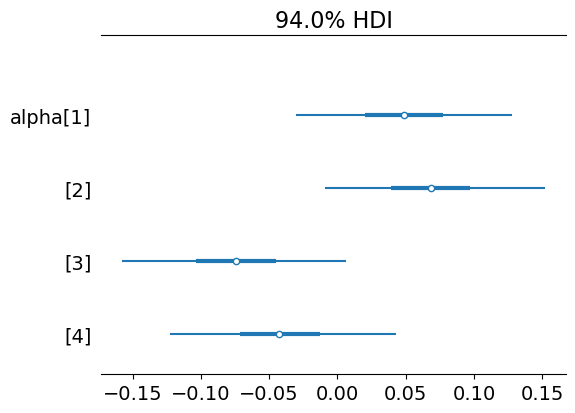

In [6]:
az.plot_forest(trace, var_names=["alpha"], combined=True)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

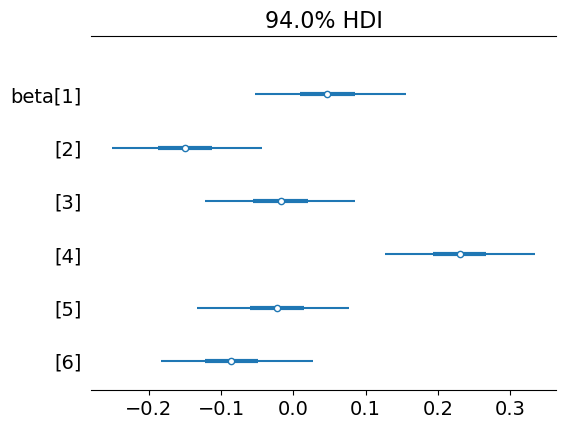

In [7]:
az.plot_forest(trace, var_names=["beta"], combined=True)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

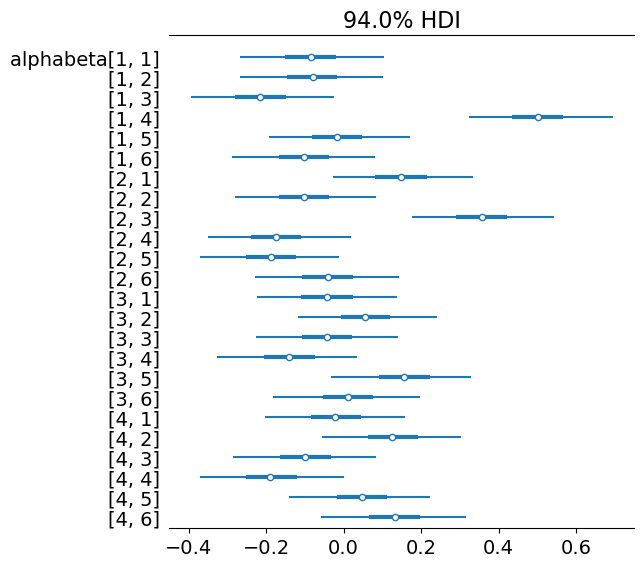

In [8]:
az.plot_forest(trace, var_names=["alphabeta"], combined=True)

## Model 2 with corner constraints

In [9]:
with pm.Model(coords=coords) as m:
    apa_data = pm.Data("apa_data", data.apa, mutable=False)
    time_idx_data = pm.Data("time_idx_data", time_idx, dims="id", mutable=False)
    conc_idx_data = pm.Data("conc_idx_data", conc_idx, dims="id", mutable=False)

    mu0 = pm.Normal("mu0", 0, tau=0.0001)
    _alpha = pm.Normal("_alpha", 0, tau=0.0001, dims="conc")
    _beta = pm.Normal("_beta", 0, tau=0.0001, dims="time")
    _alphabeta = pm.Normal("_alphabeta", 0, tau=0.0001, dims=("conc", "time"))
    tau = pm.Gamma("tau", 0.001, 0.001)
    sigma = pm.Deterministic("sigma", 1 / tau**0.5)

    # corner constraints: sets the first element of a dimension to zero
    alpha = pm.Deterministic("alpha", st.set_subtensor(_alpha[0], 0), dims="conc")
    beta = pm.Deterministic("beta", st.set_subtensor(_beta[0], 0), dims="time")
    _alphabeta = st.set_subtensor(_alphabeta[:, 0], 0)
    alphabeta = pm.Deterministic(
        "alphabeta", st.set_subtensor(_alphabeta[0, :], 0), dims=("conc", "time")
    )

    mu = (
        mu0
        + alpha[conc_idx_data]
        + beta[time_idx_data]
        + alphabeta[conc_idx_data, time_idx_data]
    )
    pm.Normal("apa", mu, tau=tau, observed=apa_data, dims="id")

    differences(alpha, coords["conc"])
    differences(beta, coords["time"])

    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu0, _alpha, _beta, _alphabeta, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 60 seconds.


In [10]:
az.summary(trace, var_names="~_", filter_vars="like", kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu0,0.250,0.120,0.034,0.480
tau,17.211,2.825,12.205,22.611
sigma,0.244,0.020,0.207,0.282
alpha[1],0.000,0.000,0.000,0.000
alpha[2],0.251,0.169,-0.063,0.577
alpha[3],-0.084,0.168,-0.406,0.219
alpha[4],-0.027,0.171,-0.364,0.282
beta[1],0.000,0.000,0.000,0.000
beta[2],-0.194,0.170,-0.512,0.122
beta[3],-0.192,0.170,-0.508,0.129


In [11]:
%watermark -n -u -v -iv -p aesara,aeppl

Last updated: Fri Feb 03 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

aesara: 2.8.10
aeppl : 0.1.1

pymc    : 5.0.1
pandas  : 1.5.3
numpy   : 1.24.1
arviz   : 0.14.0
pytensor: 2.8.11

